In [0]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import random
import torch.nn.init as init
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive

drive.mount('/content/drive')
dataset_zip = np.load("/content/drive/My Drive/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda': 
    torch.cuda.manual_seed_all(777)
print(device)

cuda


In [0]:
class dSpriteDataSet(torch.utils.data.Dataset):
    def __init__(self, np_imgs):
        self.data = np_imgs

    def __len__(self):
        return len(self.data)
     
    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx])


shape_type = 1
shape_idx = (dataset_zip['latents_values'][:, 1] == shape_type)
shape_imgs = dataset_zip['imgs'][shape_idx] 
dataset = dSpriteDataSet(shape_imgs.reshape(-1, 1, 64, 64))

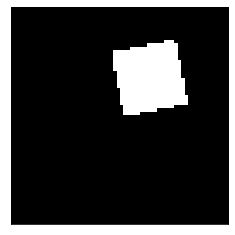

mean :  0.090087890625
min :  0
max :  1
shape :  (1, 64, 64)


In [0]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
random_index = random.randrange(0, len(dataset))
ax.imshow(dataset.data[random_index].reshape(64, 64), cmap='Greys_r', interpolation='nearest')
plt.show()
print('mean : ', dataset.data[random_index].mean())
print('min : ', dataset.data[random_index].min())
print('max : ', dataset.data[random_index].max())
print('shape : ', dataset.data[random_index].shape)

In [0]:
def reparametrize(mu, sig):
    eps = torch.randn_like(sig).to(device)
    return mu + sig*eps


def reverseKL_STD(mu, sig):
    reverse_kl = -torch.log(sig) + ((sig * sig + mu * mu) / 2.0) - 0.5
    return torch.mean(reverse_kl)


def KLD(sampler_mu, sampler_sig, mu, sig): #KL(N(self.mu, self.sig) || N(tar_mu, tar_sig))
    kld = torch.log(sig) - torch.log(sampler_sig) + ((sampler_sig * sampler_sig + (sampler_mu - mu) * (sampler_mu - mu)) / (2.0 * sig * sig)) - 0.5
    return torch.mean(kld)


def log_likelihood(x, mu, sig): # Factorized Normal distribution
    return -torch.mean(torch.log(sig) + 0.5 * (np.log(2.0 * np.pi) + ((mu - x)/sig)**2))


class View(torch.nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class VAE2(torch.nn.Module):
    """TEST MODEL FOR DSPRITES DATASET"""

    def __init__(self, m_dim=5, z_dim=5):
        super(VAE2, self).__init__()
        self.m_dim = m_dim
        self.z_dim = z_dim
        self.outer_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 4, 2, 1),          # B,  32, 32, 32
            torch.nn.ReLU(True),
            torch.nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            torch.nn.ReLU(True),
            torch.nn.Conv2d(32, 32, 4, 2, 1),          # B,  32,  8,  8
            torch.nn.ReLU(True),
            torch.nn.Conv2d(32, 64, 4, 2, 1),          # B,  32,  4,  4
            torch.nn.ReLU(True),
            View((-1, 64*4*4)),                  # B, 512
            torch.nn.Linear(64*4*4, 256),              # B, 256
            torch.nn.ReLU(True),
            torch.nn.Linear(256, self.m_dim*2),             # B, z_dim*2
        ).to(device)


        self.inner_encoder = torch.nn.Sequential(
            torch.nn.Linear(self.m_dim,   self.m_dim*16),
            torch.nn.ReLU(True),
            torch.nn.Linear(self.m_dim*16, self.m_dim*16),
            torch.nn.ReLU(True),
            torch.nn.Linear(self.m_dim*16, self.z_dim*2),
        ).to(device)


        self.inner_decoder = torch.nn.Sequential(
            torch.nn.Linear(self.z_dim,   self.m_dim*8),
            torch.nn.ReLU(True),
            torch.nn.Linear(self.m_dim*8, self.m_dim*16),
            torch.nn.ReLU(True),
            torch.nn.Linear(self.m_dim*16, self.m_dim*16),
            torch.nn.ReLU(True),
            torch.nn.Linear(self.m_dim*16, self.m_dim*2),
        ).to(device)


        self.outer_decoder = torch.nn.Sequential(
            torch.nn.Linear(self.z_dim + self.m_dim, 256),               # B, 256
            torch.nn.ReLU(True),
            torch.nn.Linear(256, 64*4*4),              # B, 512
            torch.nn.ReLU(True),
            View((-1, 64, 4, 4)),                # B,  32,  4,  4
            torch.nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  32,  8,  8
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 16, 16
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(32, 1, 4, 2, 1), # B,  1, 64, 64
            torch.nn.Sigmoid()
        ).to(device)
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def _outer_encode(self, x):
        qmx = self.outer_encoder(x)
        qmx_mu = qmx[:, :self.m_dim]
        qmx_log_var = qmx[:, self.m_dim:]
        qmx_sig = torch.exp(0.5 * qmx_log_var)
        return qmx_mu, qmx_sig

    def _inner_encode(self, m):
        qzm = self.inner_encoder(m)
        qzm_mu = qzm[:, :self.z_dim]
        qzm_log_var = qzm[:, self.z_dim:]
        qzm_sig = torch.exp(0.5 * qzm_log_var)
        return qzm_mu, qzm_sig
    
    def _inner_decode(self, z):
        pmz = self.inner_decoder(z)
        pmz_mu = pmz[:, :self.m_dim]
        pmz_log_var = pmz[:, self.m_dim:]
        pmz_sig = torch.exp(0.5 * pmz_log_var)
        return pmz_mu, pmz_sig

    def _outer_decode(self, z, m):
        return self.outer_decoder(torch.cat([z, m], dim=1))

    def forward(self, x, mc_size):
        qmx_mu, qmx_sig = self._outer_encode(x)
        qzm_mu, qzm_sig = self._inner_encode(reparametrize(qmx_mu, qmx_sig))
        qzm = reparametrize(qzm_mu, qzm_sig)
        pmz_mu, pmz_sig = self._inner_decode(qzm)
        x_recon1 = self._outer_decode(reparametrize(qzm_mu, qzm_sig), reparametrize(qmx_mu, qmx_sig)).view(x.size())
        x_recon2 = self._outer_decode(qzm, reparametrize(pmz_mu, pmz_sig)).view(x.size())
        mc_qzx_mu, mc_qzx_sig = self._inner_encode(reparametrize(qmx_mu.repeat(mc_size, 1), qmx_sig.repeat(mc_size, 1)))
        return qmx_mu, qmx_sig, qzm_mu, qzm_sig, pmz_mu, pmz_sig, mc_qzx_mu, mc_qzx_sig, x_recon1, x_recon2



def kaiming_init(m):
    if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)

In [0]:
mb_size = 256
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=mb_size,
                                     shuffle=True,
                                     drop_last=True)

X_DIM = 1 * 64 * 64
M_DIM = 4
Z_DIM = 4
model = VAE2(m_dim=M_DIM, z_dim=Z_DIM)
solver = optim.Adam(model.parameters(), lr=1e-4)

In [0]:
model_save_name = 'SQUARE0609.pt'
path = "/content/drive/My Drive/" + model_save_name
model.load_state_dict(torch.load(path))
model.eval()

VAE2(
  (outer_encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): View()
    (9): Linear(in_features=1024, out_features=256, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=256, out_features=8, bias=True)
  )
  (inner_encoder): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=8, bias=True)
  )
  (inner_decoder): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU(inplac

In [0]:
num_epochs = 100
beta = 15.0

mc_size = 64

ib = torch.zeros(4, dtype=torch.float).to(device)
for epoch in range(num_epochs):
    RECON1_AVG = 0.0
    RECON2_AVG = 0.0
    M_KLD_AVG = 0.0
    IBC_AVG = 0.0
    UNDESIRED_INFO = 0.0
    ib.fill_(0)
    for _, X in enumerate(loader):

        if beta > 15.0:
            beta -= 0.01 / len(loader)


        X = X.float().to(device)

        solver.zero_grad()
        qmx_mu, qmx_sig, qzm_mu, qzm_sig, pmz_mu, pmz_sig, mc_qzx_mu, mc_qzx_sig, x_recon1, x_recon2 = model(X, mc_size)
        recon_loss1 = torch.nn.functional.binary_cross_entropy(x_recon1, X, reduction='mean').to(device) * X_DIM
        recon_loss2 = torch.nn.functional.binary_cross_entropy(x_recon2, X, reduction='mean').to(device) * X_DIM
        middle_kld = KLD(qmx_mu, qmx_sig, pmz_mu, pmz_sig) * M_DIM

        undesired_info = KLD(qzm_mu.repeat(mc_size, 1), qzm_sig.repeat(mc_size, 1), mc_qzx_mu, mc_qzx_sig) * Z_DIM
        ib_constraint = reverseKL_STD(mc_qzx_mu, mc_qzx_sig) * Z_DIM

        loss = 2.0 * recon_loss1 + recon_loss2 + middle_kld + beta * ib_constraint + 0.01 * undesired_info


        ib += torch.mean(-torch.log(qzm_sig) + ((qzm_sig * qzm_sig + qzm_mu * qzm_mu) / 2.0) - 0.1, dim=0)

        loss.backward()
        RECON1_AVG += recon_loss1.item()
        RECON2_AVG += recon_loss2.item()
        M_KLD_AVG += middle_kld.item()
        IBC_AVG += ib_constraint.item() 
        UNDESIRED_INFO += undesired_info.item()
        solver.step()
    
    RECON1_AVG /= (len(loader) * X_DIM)
    RECON2_AVG /= (len(loader) * X_DIM)
    M_KLD_AVG /= (len(loader) * M_DIM)
    IBC_AVG /= (len(loader) * Z_DIM)
    UNDESIRED_INFO /= (len(loader) * Z_DIM)
    print('beta:', beta, 'RECON1:', RECON1_AVG, 'RECON2:', RECON2_AVG, 'M_KLD:',M_KLD_AVG, 'IBC', IBC_AVG, 'UNDESIRED_INFO', UNDESIRED_INFO)
    print(ib / len(loader))

beta: 15.0 RECON1: 0.004329826998825107 RECON2: 0.016579284901187444 M_KLD: 4.269367504119873 IBC 2.1830777704715727 UNDESIRED_INFO 0.007599608129627692
tensor([3.3325, 2.0998, 1.5699, 3.3301], device='cuda:0',
       grad_fn=<DivBackward0>)
beta: 15.0 RECON1: 0.003687331045997174 RECON2: 0.016260171582689508 M_KLD: 4.250355541706085 IBC 2.189216521382332 UNDESIRED_INFO 0.007657078136980999
tensor([3.3415, 2.1043, 1.5703, 3.3407], device='cuda:0',
       grad_fn=<DivBackward0>)
beta: 15.0 RECON1: 0.0029498798944890344 RECON2: 0.016005538902633513 M_KLD: 4.271411953866481 IBC 2.198608114570379 UNDESIRED_INFO 0.007413617879501544
tensor([3.3501, 2.1121, 1.5797, 3.3525], device='cuda:0',
       grad_fn=<DivBackward0>)
beta: 15.0 RECON1: 0.0029934922936566484 RECON2: 0.015935969733012218 M_KLD: 4.268851941823959 IBC 2.205491886784633 UNDESIRED_INFO 0.007305085161836662
tensor([3.3600, 2.1118, 1.5909, 3.3593], device='cuda:0',
       grad_fn=<DivBackward0>)
beta: 15.0 RECON1: 0.002904721173

KeyboardInterrupt: ignored

In [0]:
model_save_name = 'SQUARE0609_B15.pt'
path = "/content/drive/My Drive/" + model_save_name
torch.save(model.state_dict(), path)

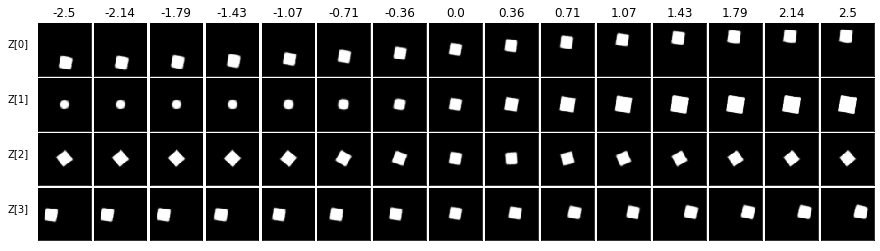

In [0]:
n_col = 15
latent_size = 4
fig = plt.figure(figsize=(n_col, latent_size))

half_range = 2.5

base_z = 0.0


data = torch.zeros(size=(n_col, latent_size), dtype=torch.float).to(device)
data.fill_(base_z)


for i in range(n_col):
    data[i][0] = -half_range + (i * 2.0 * half_range )/(n_col - 1.0)

pm_mu, pm_sig = model._inner_decode(data)
sample = model._outer_decode(data, pm_mu).to(device)
sample = sample.cpu().data.numpy()



ax = fig.add_subplot(latent_size, n_col, 1, xticks=[], yticks=[])
ax.set_title(round(-half_range + (0 * 2.0 * half_range )/(n_col - 1.0), 2))
ax.set_ylabel('Z['+str(0)+']', fontsize=10, rotation=0, labelpad=20)
ax.imshow(sample[0][0], cmap='Greys_r', interpolation='nearest')

for i in range(1, n_col):
    ax = fig.add_subplot(latent_size, n_col, i+1, xticks=[], yticks=[])
    ax.set_title(round(-half_range + (i * 2.0 * half_range )/(n_col - 1.0), 2))
    ax.imshow(sample[i][0], cmap='Greys_r', interpolation='nearest')


for k in range(1, latent_size):
    data = torch.zeros(size=(n_col, latent_size), dtype=torch.float).to(device)
    data.fill_(base_z)
    for i in range(n_col):
        data[i][k] = -half_range + (i * 2.0 * half_range )/(n_col - 1.0)
    pm_mu, pm_sig = model._inner_decode(data)
    sample = model._outer_decode(data, pm_mu).to(device)
    sample = sample.cpu().data.numpy()


    ax = fig.add_subplot(latent_size, n_col, k * n_col + 1, xticks=[], yticks=[])
    ax.set_ylabel('Z['+str(k)+']',rotation=0, labelpad=20)
    ax.imshow(sample[0][0], cmap='Greys_r', interpolation='nearest')
    for i in range(1, n_col):
        ax = fig.add_subplot(latent_size, n_col, k * n_col + i+1, xticks=[], yticks=[])
        ax.imshow(sample[i][0], cmap='Greys_r', interpolation='nearest')
plt.subplots_adjust(hspace=0.04, wspace=0.04)
plt.show()
